In [ ]:
def dms_to_decimal(degrees, minutes, seconds):
    return degrees + minutes / 60 + seconds / 3600

# Пример для широты и долготы
print(dms_to_decimal(40, 43, 42))  # 40°43′42″ с.ш.
print(dms_to_decimal(73, 59, 39))  # 73°59′39″ з.д.

# Разархивируем данные

In [ ]:
# !unzip web-traffic-time-series-forecasting.zip
# !unzip имя_файла.zip -d /путь/к/директории
# !tar -xf data/new-york-city-taxi-fare-prediction.zip

# Импорт библиотек

In [104]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import holidays
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tqdm import tqdm_notebook, tqdm
import warnings
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")

seed = 42
random.seed(seed)
np.random.seed(seed)

In [105]:
def reduce_mem_usage(df: pd.DataFrame) -> pd.DataFrame:
    """ Проходит по всем столбцам DataFrame и изменяет тип данных
        для уменьшения использования памяти.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype.name

        if col_type not in ['object', 'category', 'datetime64[ns, UTC]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [106]:
def evaluate_models(models, model_names, X, Y) -> pd.DataFrame:
    """
    Функция для оценки списка моделей по метрикам MAE, MSE, RMSE, R² и MAPE.

    Параметры:
    models (list): Список обученных моделей
    model_names (list): Список названий моделей
    X (numpy.ndarray): Набор данных для предсказания, shape (n_samples, n_features)
    Y (numpy.ndarray): Истинные ответы, shape (n_samples,)
    
    Возвращает:
    pandas.DataFrame: Таблица с метриками для каждой модели
    """

    if len(models) != len(model_names):
        raise ValueError("Списки моделей и названий моделей должны быть одинаковой длины")

    results = []
    for model, name in zip(models, model_names):
        y_pred = model.predict(X)
        
        # Вычисление метрик регрессии
        mae = mean_absolute_error(Y, y_pred)
        mse = mean_squared_error(Y, y_pred)
        rmse = np.sqrt(mse)  # Корень из среднеквадратичной ошибки
        r2 = r2_score(Y, y_pred)
        
        # Средняя абсолютная процентная ошибка (MAPE)
        mape = np.mean(np.abs((Y - y_pred) / Y)) * 100 if np.all(Y != 0) else None

        results.append({
            'Model': name,
            'MAE': round(mae, 4),
            'MSE': round(mse, 4),
            'RMSE': round(rmse, 4),
            'R²': round(r2, 4),
            'MAPE': round(mape, 4)
        })
    
    results_df = pd.DataFrame(results)
    return results_df

# Анализ данных и обработка

## Инициализируем все

In [107]:
data = pd.read_csv('data/train.csv', nrows=500000)
data = data[data.fare_amount > 1]
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [108]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 499960 entries, 0 to 499999
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   key                499960 non-null  object 
 1   fare_amount        499960 non-null  float64
 2   pickup_datetime    499960 non-null  object 
 3   pickup_longitude   499960 non-null  float64
 4   pickup_latitude    499960 non-null  float64
 5   dropoff_longitude  499955 non-null  float64
 6   dropoff_latitude   499955 non-null  float64
 7   passenger_count    499960 non-null  int64  
dtypes: float64(5), int64(1), object(2)
memory usage: 34.3+ MB


In [109]:
data.isnull().sum()

key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    5
dropoff_latitude     5
passenger_count      0
dtype: int64

заполним пока пропуски медианой

In [110]:
data['dropoff_longitude'] = data['dropoff_longitude'].fillna(data['dropoff_longitude'].median())
data['dropoff_latitude'] = data['dropoff_latitude'].fillna(data['dropoff_latitude'].median())

In [111]:
data.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


<Axes: >

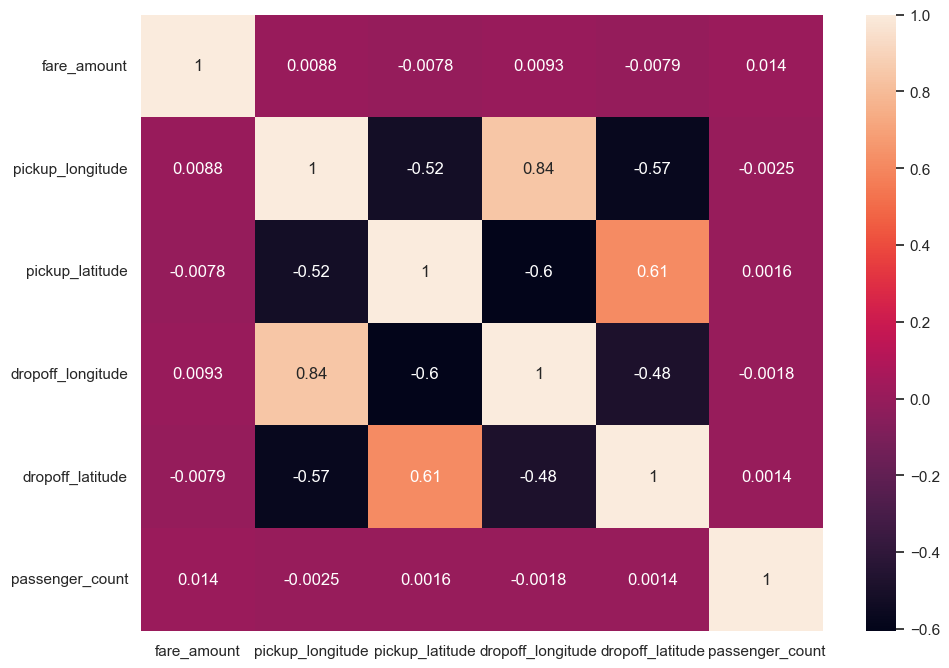

In [112]:
corr_matrix = data[data.select_dtypes(include=[np.number]).columns.to_list()].corr()

sns.set(rc={'figure.figsize': (11, 8)})

sns.heatmap(corr_matrix, annot=True)

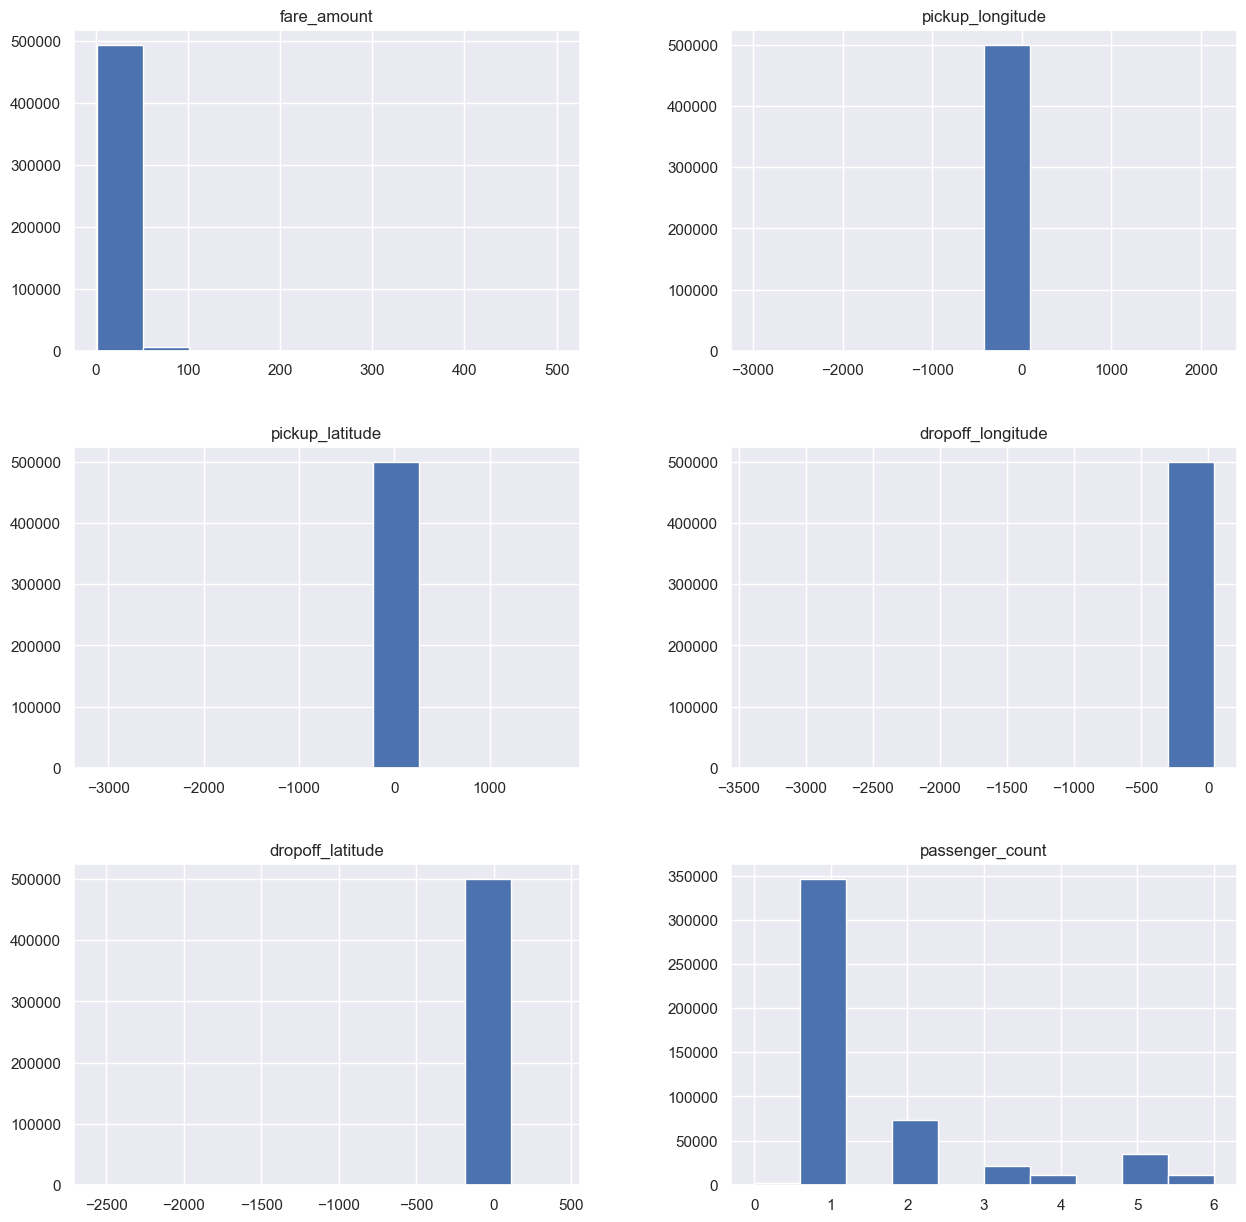

In [113]:
data.hist(figsize=(15, 15));

## Гипотезы

In [114]:
data

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
...,...,...,...,...,...,...,...,...
499995,2015-05-07 18:45:12.0000004,7.0,2015-05-07 18:45:12 UTC,-73.978775,40.766724,-73.966072,40.758537,1
499996,2010-09-13 12:11:34.0000004,13.7,2010-09-13 12:11:34 UTC,-74.002932,40.718408,-74.009442,40.710952,1
499997,2014-08-25 00:22:20.0000001,25.0,2014-08-25 00:22:20 UTC,-73.983885,40.725611,-73.896482,40.700980,1
499998,2015-01-12 12:17:32.0000001,6.5,2015-01-12 12:17:32 UTC,-73.974617,40.756512,-73.970184,40.764801,6


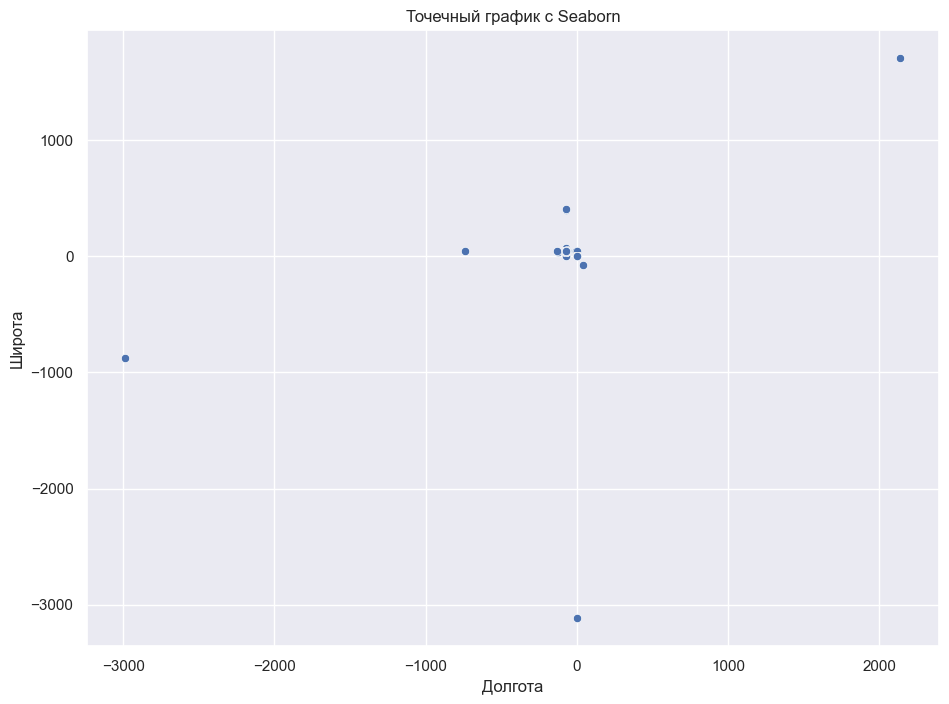

In [115]:
sns.scatterplot(x='pickup_longitude', y='pickup_latitude', data=data)
plt.title('Точечный график с Seaborn')  # Заголовок
plt.xlabel('Долгота')  # Метка для оси X
plt.ylabel('Широта')  # Метка для оси Y
plt.show()

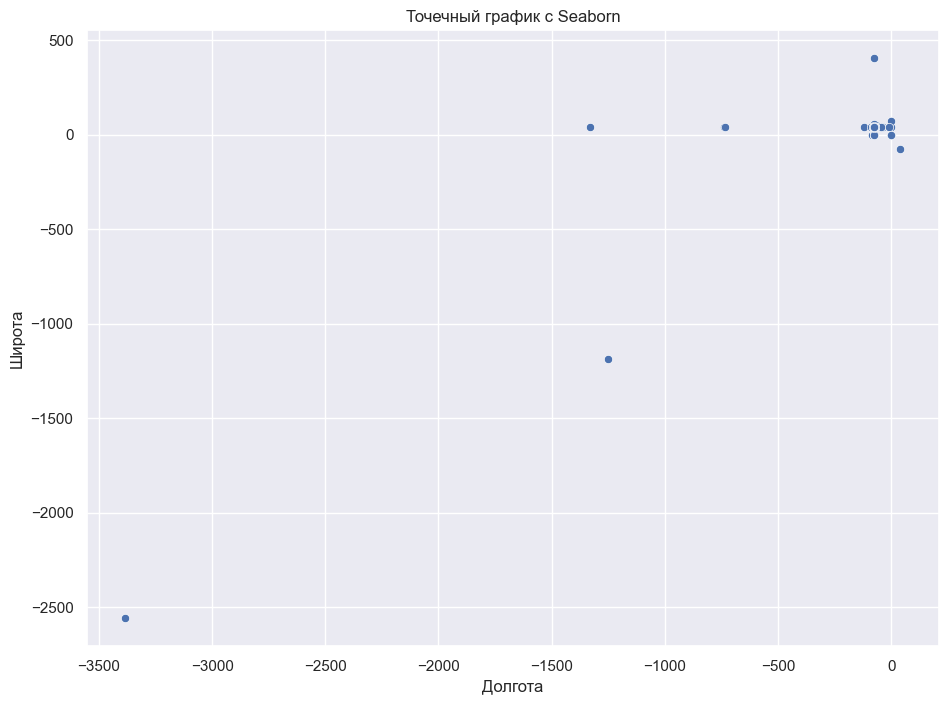

In [116]:
sns.scatterplot(x='dropoff_longitude', y='dropoff_latitude', data=data)
plt.title('Точечный график с Seaborn')  # Заголовок
plt.xlabel('Долгота')  # Метка для оси X
plt.ylabel('Широта')  # Метка для оси Y
plt.show()

### Заказы которые близкие к центру Нью-Йорка (начинаются)

Data points within threshold: 490142


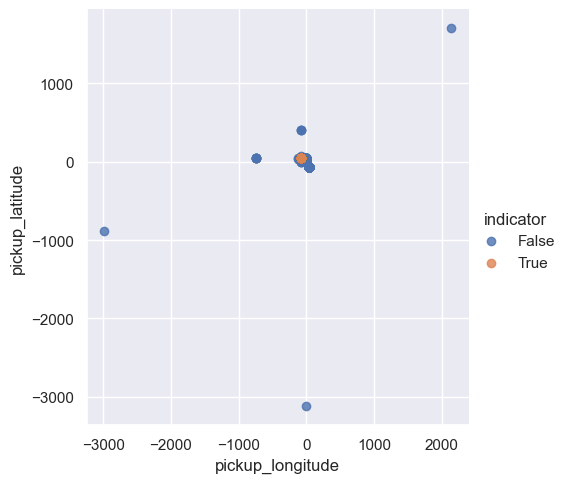

In [117]:
sns.set()
local_coord = [-73.9855, 40.7580]  # точка, относительно которой определяем порог дистанции
euc_dist_th = 2  # порог расстояния

# Вычисляем евклидово расстояние
euclid_distance = data[['pickup_longitude', 'pickup_latitude']].apply(
    lambda x: np.sqrt((x['pickup_longitude'] - local_coord[0]) ** 2 + (x['pickup_latitude'] - local_coord[1]) ** 2), axis=1
)

# Определяем, входит ли точка в порог
indicator = pd.Series(euclid_distance <= euc_dist_th, name='indicator')

print("Data points within threshold:", sum(indicator))

# Визуализация региона
# Заменяем аргументы для lmplot
sns.lmplot(
    x='pickup_longitude', y='pickup_latitude', data=pd.concat([data, indicator], axis=1),
    hue='indicator', scatter_kws={'marker': '.'}, fit_reg=False, height=5
)

### Заказы которые близкие к центру Нью-Йорка (заканчиваются)

Data points within threshold: 490132


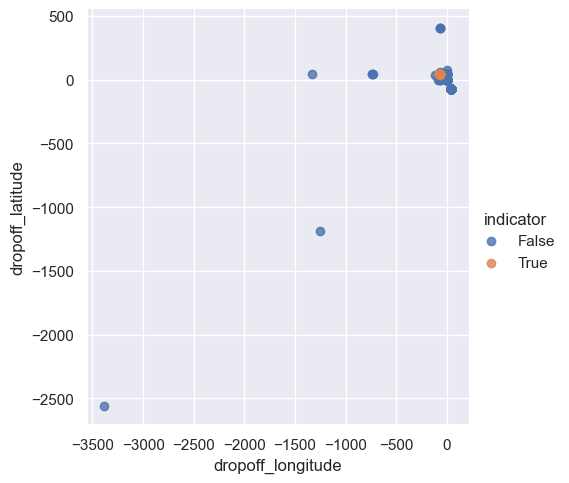

In [118]:
sns.set()
local_coord = [-73.9855, 40.7580]  # точка, относительно которой определяем порог дистанции
euc_dist_th = 2  # порог расстояния

# Вычисляем евклидово расстояние
euclid_distance = data[['dropoff_longitude', 'dropoff_latitude']].apply(
    lambda x: np.sqrt((x['dropoff_longitude'] - local_coord[0]) ** 2 + (x['dropoff_latitude'] - local_coord[1]) ** 2), axis=1
)

# Определяем, входит ли точка в порог
indicator = pd.Series(euclid_distance <= euc_dist_th, name='indicator')

print("Data points within threshold:", sum(indicator))

# Визуализация региона
# Заменяем аргументы для lmplot
sns.lmplot(
    x='dropoff_longitude', y='dropoff_latitude', data=pd.concat([data, indicator], axis=1),
    hue='indicator', scatter_kws={'marker': '.'}, fit_reg=False, height=5
)

# Сгенерируем и обработаем признаки

In [119]:
def add_holiday_feature(df, timestamp_col, country='USA'):
    """
    Добавляет бинарный признак праздников в DataFrame на основе заданной страны.

    Параметры:
    df (pd.DataFrame): DataFrame с колонкой, содержащей метки времени.
    timestamp_col (str): Название колонки с метками времени.
    country (str): Код страны (например, 'US' для США, 'RU' для России).

    Возвращает:
    pd.DataFrame: DataFrame с добавленной колонкой 'is_holiday' (1 - праздник, 0 - не праздник).
    """
    # Приводим колонку меток времени к формату даты (игнорируя время)
    df['date_only'] = pd.to_datetime(df[timestamp_col]).dt.date
    
    # Создаем объект праздников для указанной страны и приводим его к формату дат
    country_holidays = [d for d in holidays.CountryHoliday(country, years=range(2000, 2024))]
    
    # Определяем, является ли дата праздником: 1 для праздника, 0 для обычного дня
    df['is_holiday'] = df['date_only'].isin(country_holidays).astype(int)
    
    # Удаляем временную колонку 'date_only'
    df.drop(columns='date_only', inplace=True)
    
    return df

In [120]:
def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Рассчитывает расстояние по сфере (в километрах) между двумя точками с известной широтой и долготой
    с использованием формулы Хаверсина.
    
    Параметры:
    lat1, lon1 (float): Координаты первой точки (в градусах).
    lat2, lon2 (float): Координаты второй точки (в градусах).
    
    Возвращает:
    float: Расстояние между точками в километрах.
    """
    # Преобразуем градусы в радианы
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Разницы в координатах
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Применяем формулу Хаверсина
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    # Радиус Земли в километрах и вычисление расстояния
    return 6371.0 * c

In [121]:
def calculate_relative_coordinates_flat(df, lat_col, lon_col, center_lat, center_lon):
    """
    Пересчитывает координаты относительно центра (center_lat, center_lon) в километрах.
    Параметры:
    - df: DataFrame с исходными координатами
    - lat_col: имя столбца с широтой
    - lon_col: имя столбца с долготой
    - center_lat: широта центральной точки
    - center_lon: долгота центральной точки
    
    Возвращает:
    - DataFrame с новыми столбцами 'relative_lat' и 'relative_lon', представляющими относительные координаты в км.
    """
    # Коэффициент перевода градусов широты в километры
    lat_to_km = 111  # 1 градус широты примерно равен 111 км
    # Вычисляем относительные координаты для широты
    df[lat_col] = (df[lat_col] - center_lat) * lat_to_km
    # Вычисляем относительные координаты для долготы с учетом кривизны Земли
    df[lon_col] = (df[lon_col] - center_lon) * lat_to_km * np.cos(np.radians(center_lat))
    return df


def manhattan_distance(lat1, lon1, lat2, lon2):
    """
    Рассчитывает расстояние Манхэттена между двумя точками с учетом приближенных коэффициентов для перевода широты и долготы в километры.
    Параметры:
    lat1, lon1 (float): Координаты первой точки.
    lat2, lon2 (float): Координаты второй точки.
    Возвращает:
    float: Манхэттенское расстояние между точками в километрах.
    """
    # Широта переводится в километры с коэффициентом 111, долгота с коэффициентом 85
    return np.abs(lat1 - lat2) * 111 + np.abs(lon1 - lon2) * 85

In [ ]:
def generate_geospatial_features(data, reference_points=None, distance_pairs=None, timestamp_col='pickup_datetime', reference_points_cols=None):
    """
    Генерирует геопространственные признаки на основе расстояний, опорных точек и временных характеристик.
    
    Параметры:
    data (pd.DataFrame): Исходный DataFrame.
    reference_points (list): Список кортежей с названиями и координатами опорных точек.
    distance_pairs (list): Список кортежей с названиями колонок для расчета расстояний.
    timestamp_col (str): Название колонки с метками времени.
    origin_lat_col, origin_lon_col (str): Названия колонок с исходными координатами для расчета до опорных точек.
    
    Возвращает:
    pd.DataFrame: DataFrame с новыми геопространственными признаками.
    """
    
    # 1. Расчет расстояний между парами координат в distance_pairs
    if distance_pairs:
        for i, (start_lon_col, start_lat_col, end_lon_col, end_lat_col) in enumerate(distance_pairs):
            # Добавляем Манхэттенское расстояние
            data[f'manhattan_distance{i}'] = manhattan_distance(data[start_lat_col], data[start_lon_col], data[end_lat_col], data[end_lon_col])
            data[f'haversine_distance{i}'] = haversine_distance(data[start_lat_col], data[start_lon_col], data[end_lat_col], data[end_lon_col])
    
    # 2. Расчет минимальных расстояний до опорных точек, если они заданы
    if reference_points and reference_points_cols:
        for ref_name, (ref_lat, ref_lon) in reference_points:
            # Вычисляем расстояние от начальных координат до текущей опорной точки
            manhattan = []
            haversine = []
            for origin_lat_col, origin_lon_col  in reference_points_cols:
                # data[f"reference_manhattan_{ref_name}_{origin_lat_col.split('_')[0]}"] = manhattan_distance(data[origin_lat_col], data[origin_lon_col], ref_lat, ref_lon)
                # data[f"reference_haversine_{ref_name}_{origin_lat_col.split('_')[0]}"] = haversine_distance(data[origin_lat_col], data[origin_lon_col], ref_lat, ref_lon)
                manhattan.append(manhattan_distance(data[origin_lat_col], data[origin_lon_col], ref_lat, ref_lon))
                haversine.append(haversine_distance(data[origin_lat_col], data[origin_lon_col], ref_lat, ref_lon))
            data[f"reference_manhattan_{ref_name}_min"] = np.max(manhattan)
            data[f"reference_manhattan_{ref_name}_max"] = np.max(manhattan)
            data[f"reference_haversine_{ref_name}_min"] = 
            data[f"reference_haversine_{ref_name}_max"] = 
    # 3. Извлечение временных характеристик из столбца меток времени
    if timestamp_col:
        # Преобразуем в datetime для возможности извлечения временных признаков
        data[timestamp_col] = pd.to_datetime(data[timestamp_col])
        
        # Извлекаем месяц, день, день недели, час и информацию о выходных
        data['month'] = data[timestamp_col].dt.month
        data['day'] = data[timestamp_col].dt.day
        data['day_of_week'] = data[timestamp_col].dt.dayofweek
        data['hour'] = data[timestamp_col].dt.hour
        data['minute'] = data[timestamp_col].dt.minute
        data['is_weekend'] = data['day_of_week'].isin([5, 6]).astype(int)
        
        # Тригонометрические признаки для часовой, месячной и дневной информации
        data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
        data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)
        data['minute_sin'] = np.sin(2 * np.pi * data['minute'] / 60)
        data['minute_cos'] = np.cos(2 * np.pi * data['minute'] / 60)
        data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
        data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
        data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 6)
        data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 6)
    
    return data

In [123]:
reference_points = [('central_park', (40.785091, -73.968285)), ('times_square', (40.758896, -73.985130)), ('wall_street', (40.7074, -74.0113))]
distance_pairs = [('pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude')]

# Генерация новых признаков
data = generate_geospatial_features(
    data,
    reference_points=reference_points,
    distance_pairs=distance_pairs,
    timestamp_col='pickup_datetime',
    reference_points_cols=[('dropoff_latitude', 'dropoff_longitude'), ('pickup_latitude', 'pickup_longitude')]
)

local_coord = [-73.9855, 40.7580]  # [долгота, широта] ЦЕНТР ГОРОДА
center_lon, center_lat = local_coord  # Подстановка значений
data = calculate_relative_coordinates_flat(data, 'pickup_latitude', 'pickup_longitude', center_lat, center_lon)
data = calculate_relative_coordinates_flat(data, 'dropoff_latitude', 'dropoff_longitude', center_lat, center_lon)
# data['chebyshev_distance'] = chebyshev_distance(data['pickup_latitude'], data['pickup_longitude'], data['dropoff_latitude'], data['dropoff_longitude'])
data

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,manhattan_distance0,haversine_distance0,min_manhattan_distance,min_haversine_distance,month,day_of_week,hour,is_weekend,is_holiday
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21+00:00,11.871114,-4.071591,12.098213,-5.075142,1,1.233136,1.030764,14.965108,12.578274,6,0,17,0,0
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16+00:00,-2.568463,-5.183367,0.523984,2.664444,1,10.974111,8.450134,0.836813,0.590350,1,1,16,0,0
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00+00:00,0.232228,0.362970,-0.482785,-0.825618,2,1.911428,1.389525,0.466834,0.332072,8,3,0,0,0
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42+00:00,-0.137050,-2.759127,-0.510111,0.010212,1,3.146484,2.799270,0.636389,0.549488,4,5,4,1,0
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00+00:00,1.463405,1.110888,2.425276,2.859582,1,2.721094,1.999157,1.136069,0.990262,3,1,7,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,2015-05-07 18:45:12.0000004,7.0,2015-05-07 18:45:12+00:00,0.565433,0.968323,1.633491,0.059639,1,1.988434,1.404709,1.409040,1.021787,5,3,18,0,0
499996,2010-09-13 12:11:34.0000004,13.7,2010-09-13 12:11:34+00:00,-1.465676,-4.394712,-2.013034,-5.222328,1,1.380966,0.994184,0.552202,0.424880,9,0,12,0,0
499997,2014-08-25 00:22:20.0000001,25.0,2014-08-25 00:22:20+00:00,0.135789,-3.595179,7.484597,-6.329220,1,10.163296,7.859324,3.800460,3.072305,8,0,0,0,0
499998,2015-01-12 12:17:32.0000001,6.5,2015-01-12 12:17:32+00:00,0.915038,-0.165203,1.287736,0.754914,6,1.296894,0.994470,1.158263,0.924323,1,0,12,0,0


In [124]:
data.isnull().sum()

key                       0
fare_amount               0
pickup_datetime           0
pickup_longitude          0
pickup_latitude           0
dropoff_longitude         0
dropoff_latitude          0
passenger_count           0
manhattan_distance0       0
haversine_distance0       0
min_manhattan_distance    0
min_haversine_distance    0
month                     0
day_of_week               0
hour                      0
is_weekend                0
is_holiday                0
dtype: int64

In [125]:
data.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,manhattan_distance0,haversine_distance0,min_manhattan_distance,min_haversine_distance,month,day_of_week,hour,is_weekend,is_holiday
count,499960.000000,499960.000000,499960.000000,499960.000000,499960.000000,499960.000000,499960.000000,499960.000000,499960.000000,499960.000000,499960.000000,499960.000000,499960.000000,499960.000000,499960.000000
mean,11.359536,123.219353,-92.985680,122.997351,-93.392097,1.683441,28.038176,19.470091,209.816181,165.867623,6.268858,3.041995,13.510955,0.283197,0.022846
std,9.915921,996.919602,896.169282,991.876714,820.381771,1.307407,1183.453316,367.313286,1635.726668,1201.632969,3.437829,1.949237,6.511498,0.450552,0.149412
min,1.500000,-244861.390523,-350431.815513,-278245.539789,-288656.267343,0.000000,0.000000,0.000000,0.001424,0.001086,1.000000,0.000000,0.000000,0.000000,0.000000
25%,6.000000,-0.550553,-2.562213,-0.494556,-2.657673,1.000000,1.552130,1.214698,0.975750,0.778293,3.000000,1.000000,9.000000,0.000000,0.000000
50%,8.500000,0.312356,-0.591630,0.451760,-0.538128,1.000000,2.726427,2.117072,1.505250,1.179298,6.000000,3.000000,14.000000,0.000000,0.000000
75%,12.500000,1.545566,1.007325,1.843529,1.124763,2.000000,5.022193,3.890213,2.249721,1.788763,9.000000,5.000000,19.000000,1.000000,0.000000
max,500.000000,186201.550870,184519.159692,9655.408754,40388.312037,6.000000,609393.360782,12399.956433,349807.817483,15080.571176,12.000000,6.000000,23.000000,1.000000,1.000000


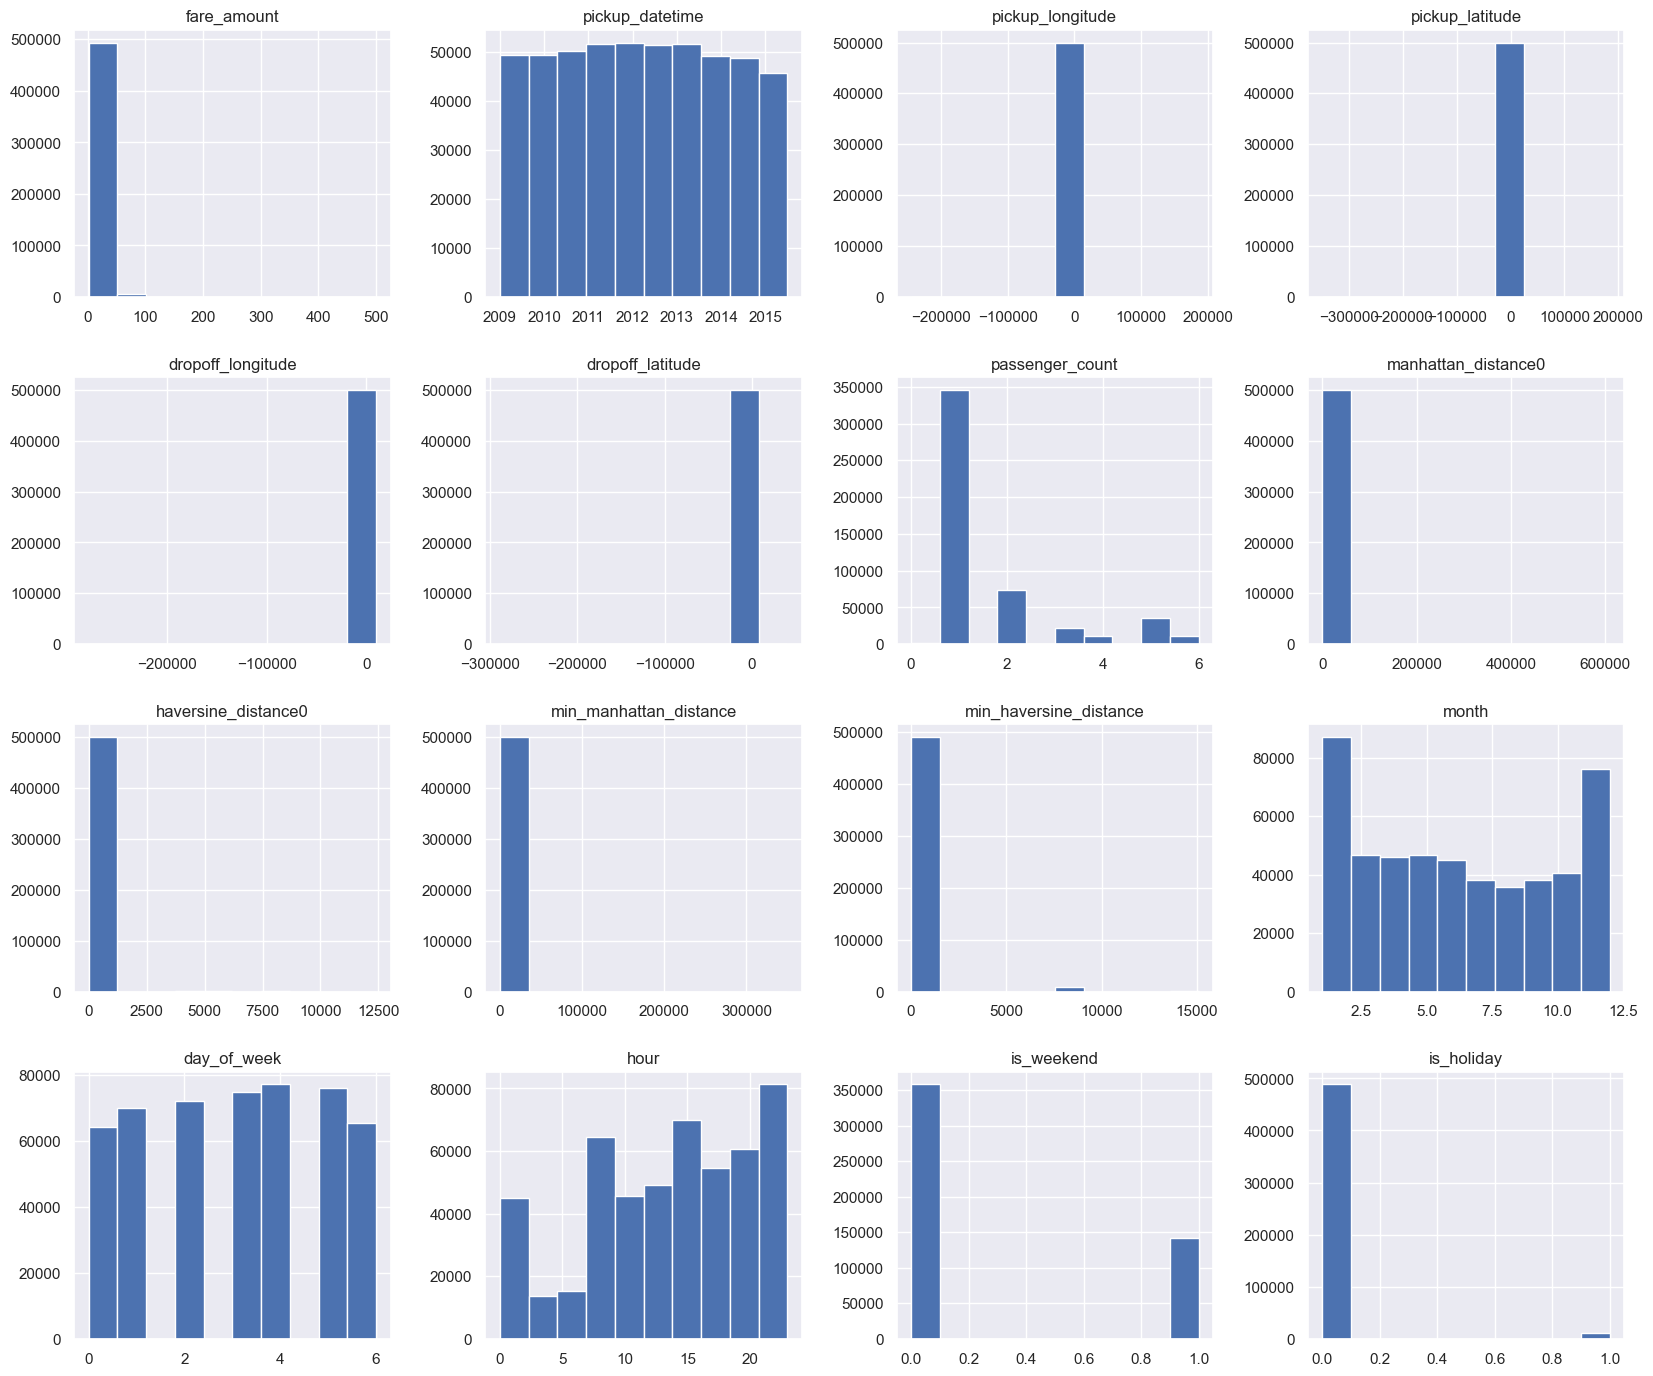

In [126]:
data.hist(figsize=(20, 17));

<Axes: >

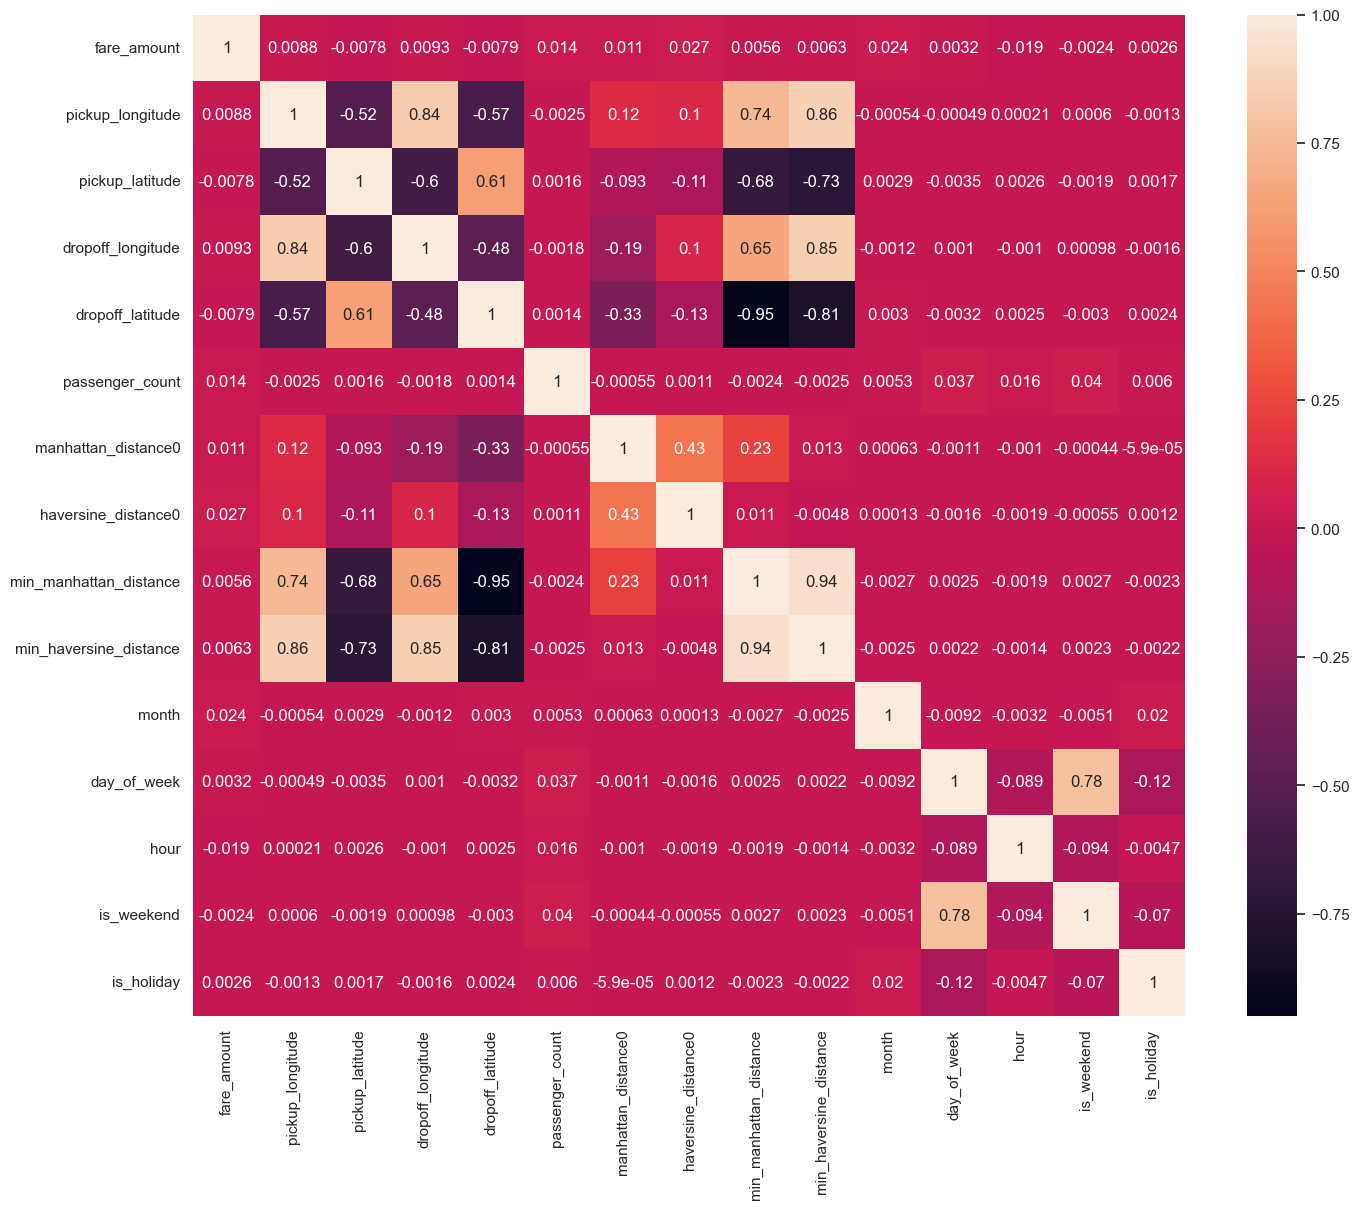

In [127]:
corr_matrix = data[data.select_dtypes(include=[np.number]).columns.to_list()]

sns.set(rc={'figure.figsize': (16, 13)})

sns.heatmap(corr_matrix.corr(), annot=True)

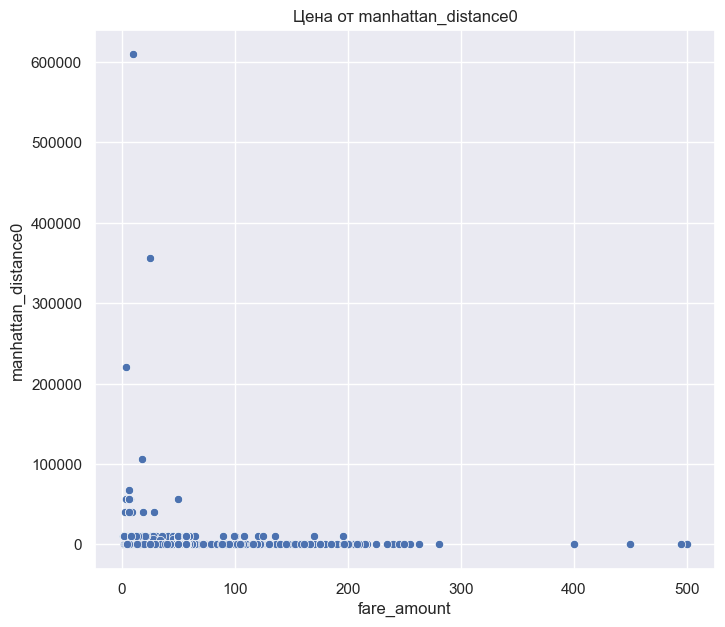

In [128]:
sns.set(rc={'figure.figsize': (8, 7)})
sns.scatterplot(x='fare_amount', y='manhattan_distance0', data=data)
plt.title('Цена от manhattan_distance0')  # Заголовок
plt.xlabel('fare_amount')  # Метка для оси X
plt.ylabel('manhattan_distance0')  # Метка для оси Y
plt.show()

In [129]:
data = data[(data['manhattan_distance0'] <= 149) & (data['manhattan_distance0'] > 2)]# & (data['fare_amount'] >= 4) & (data['fare_amount'] <= 50)]
data.shape

(320675, 17)

<Axes: >

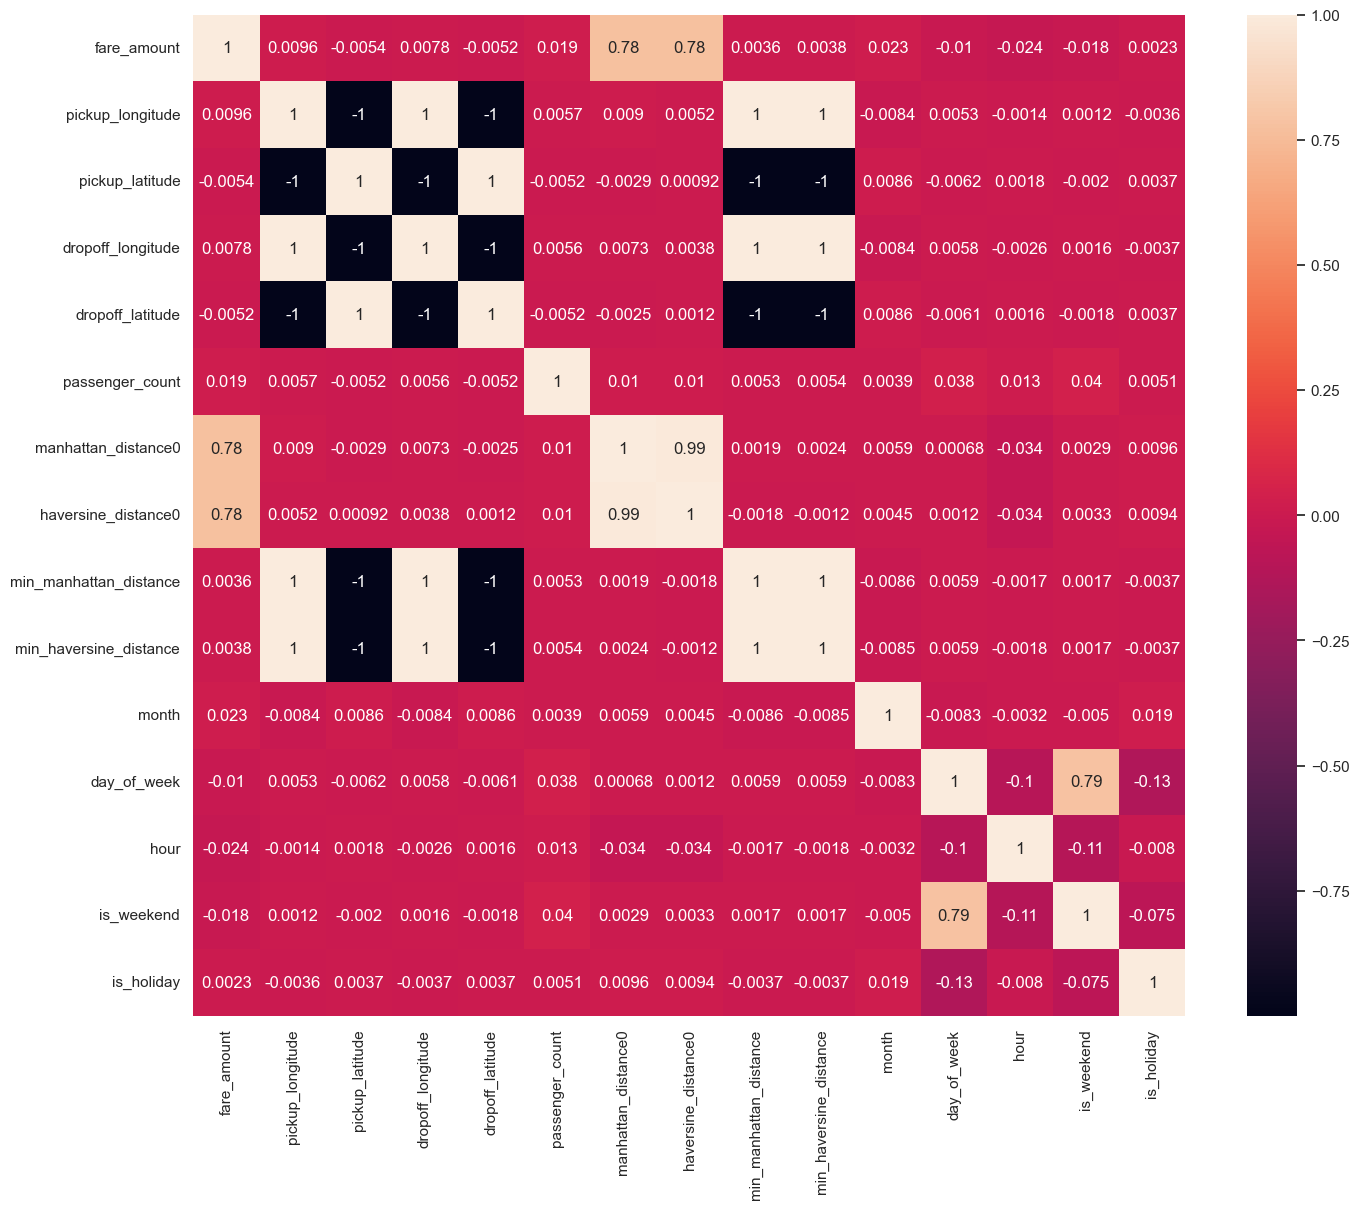

In [130]:
corr_matrix = data[data.select_dtypes(include=[np.number]).columns.to_list()]
sns.set(rc={'figure.figsize': (16, 13)})
sns.heatmap(corr_matrix.corr(), annot=True)

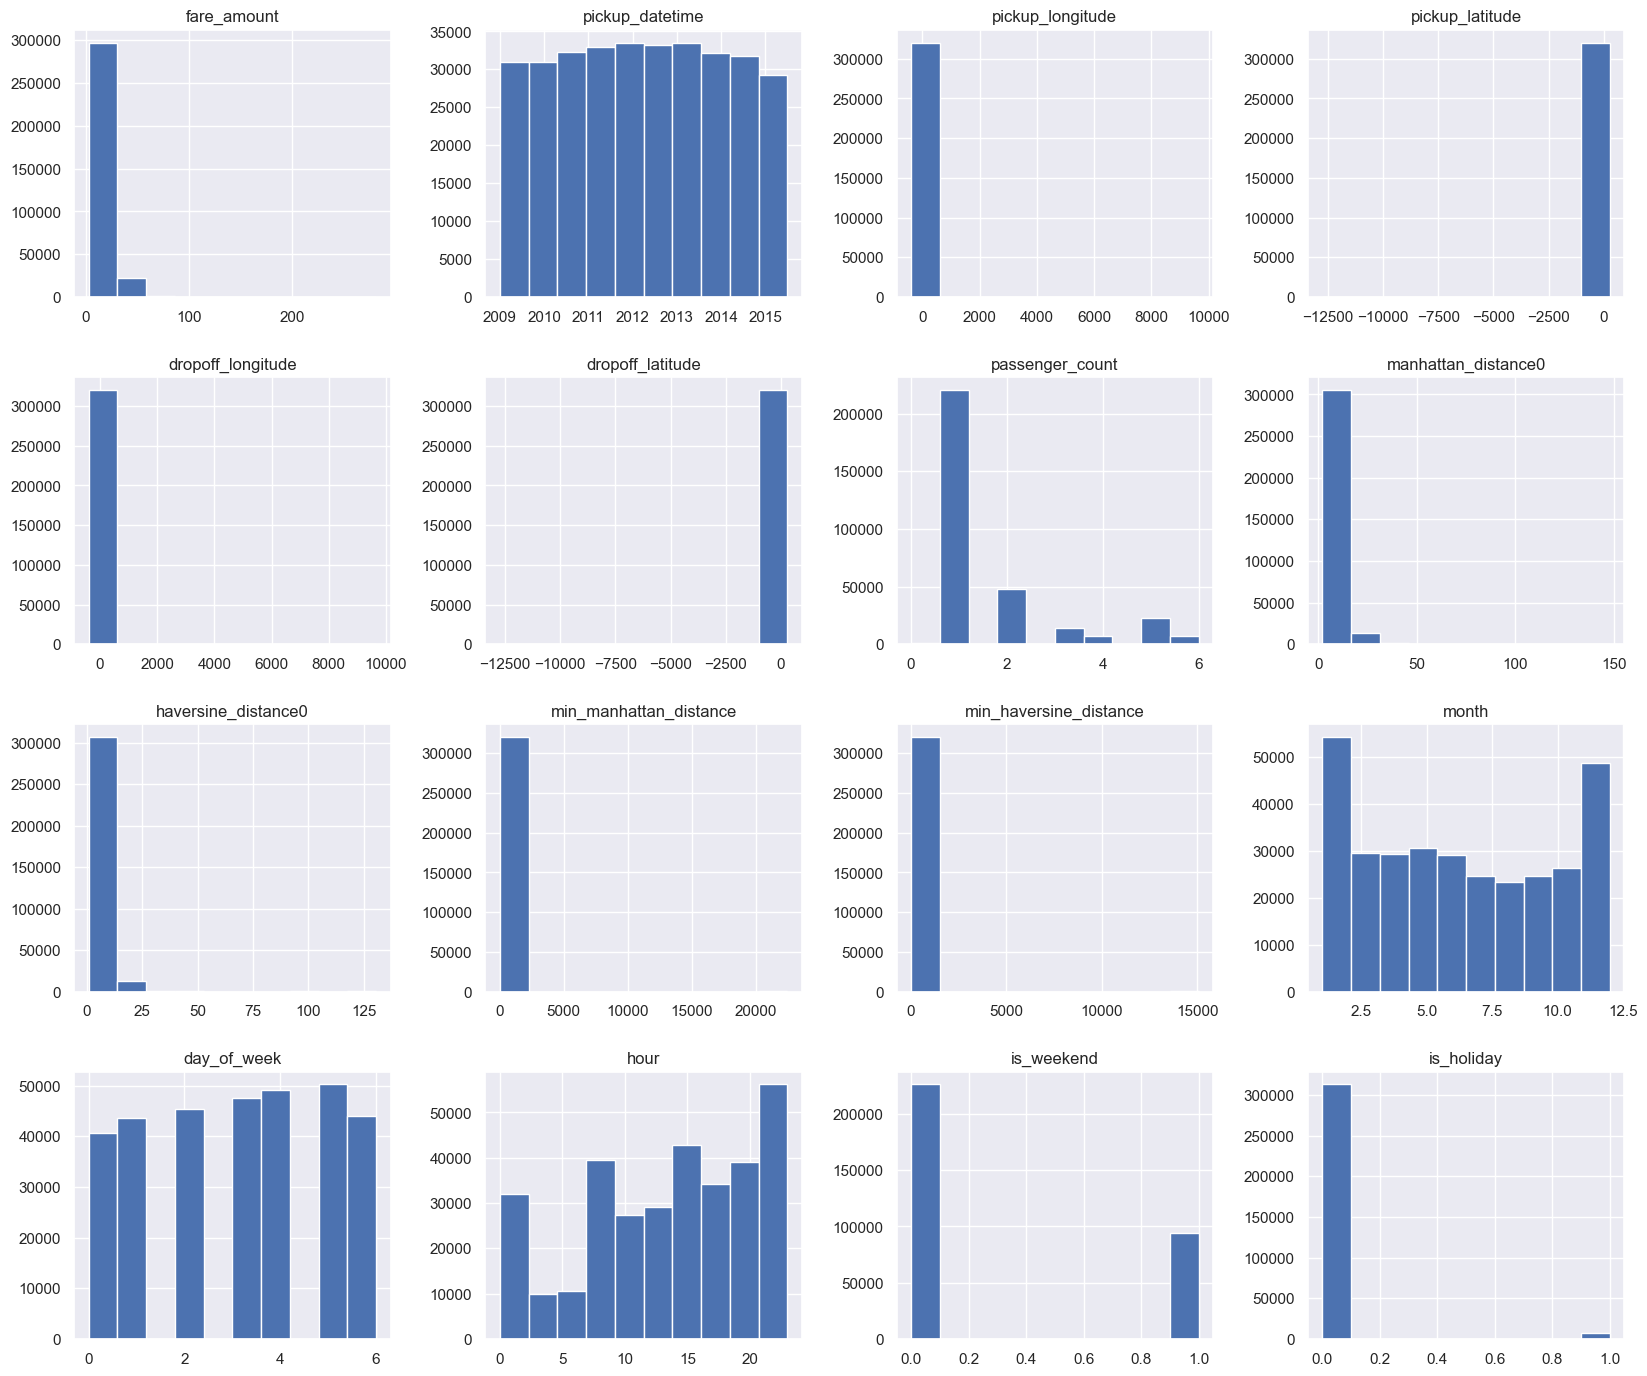

In [131]:
data.hist(figsize=(20, 17));

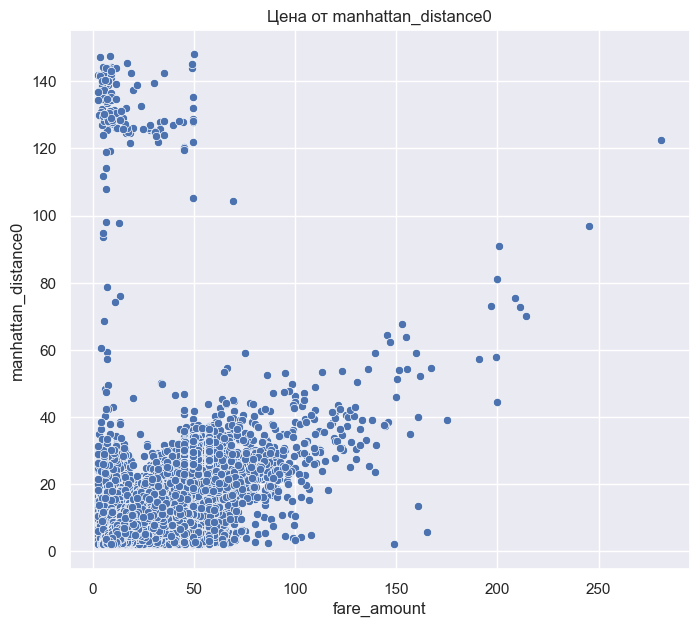

In [132]:
sns.set(rc={'figure.figsize': (8, 7)})
sns.scatterplot(x='fare_amount', y='manhattan_distance0', data=data)
plt.title('Цена от manhattan_distance0')  # Заголовок
plt.xlabel('fare_amount')  # Метка для оси X
plt.ylabel('manhattan_distance0')  # Метка для оси Y
plt.show()

In [133]:
data = data.drop(columns=['key', 'pickup_datetime'])

In [134]:
data = reduce_mem_usage(data)

Memory usage of dataframe is 33.03 MB
Memory usage after optimization is: 9.79 MB
Decreased by 70.4%


# Разделение на валидацию и тренировочную

In [135]:
X = data.drop(columns=['fare_amount'])
Y = data['fare_amount']
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, random_state=seed, shuffle=True, test_size=0.2)

# Выбор моделей

In [86]:
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [103]:
model_lr = LinearRegression(n_jobs=-1)
model_lr.fit(X_train, Y_train)

rfc = RandomForestRegressor(random_state=seed, n_jobs=-1)
rfc.fit(X_train, Y_train)

dtc = DecisionTreeRegressor(random_state=seed)
dtc.fit(X_train, Y_train)

sgd = SGDRegressor(random_state=seed, n_iter_no_change=16)
sgd.fit(X_train, Y_train)

mlpc = MLPRegressor(random_state=seed)
mlpc.fit(X_train, Y_train)

cat = CatBoostRegressor(use_best_model=True, random_state=seed, verbose=500)
cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid))

xgb = XGBRegressor(random_state=seed)
xgb.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], verbose=10)

lgbm = LGBMRegressor(random_state=seed, verbose=-1)
lgbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)])

NameError: name 'X_train' is not defined

In [88]:
res = evaluate_models(
    models=[model_lr, cat, xgb, lgbm, rfc, dtc, sgd, mlpc],
    model_names=['LinearRegression', 'CatBoostRegression', 'XGBRegression',
                 'LGBMRegression', 'RandomForestRegression', 'DecisionTreeRegression',
                 'SGDRegression', 'MLPRegression'],
    X=X_valid,
    Y=Y_valid
)
res

,Model,MAE,MSE,RMSE,R²,MAPE
0,LinearRegression,3.181641e+00,inf,6.417969e+00,NaN,2.634280e+01
1,CatBoostRegression,2.137700e+00,1.542430e+01,3.927400e+00,8.559000e-01,1.673600e+01
2,XGBRegression,2.182500e+00,1.633150e+01,4.041200e+00,8.475000e-01,1.708560e+01
3,LGBMRegression,2.284800e+00,1.682220e+01,4.101500e+00,8.429000e-01,1.816780e+01
4,RandomForestRegression,2.235900e+00,1.653650e+01,4.066500e+00,8.455000e-01,1.766570e+01
5,DecisionTreeRegression,3.221200e+00,3.421750e+01,5.849600e+00,6.804000e-01,2.512140e+01
6,SGDRegression,4.202002e+13,2.805510e+30,1.674966e+15,-2.620505e+28,3.370448e+14
7,MLPRegression,2.310900e+00,1.823110e+01,4.269800e+00,8.297000e-01,1.775210e+01


In [89]:
res[res['R²'] == res['R²'].max()]

,Model,MAE,MSE,RMSE,R²,MAPE
1,CatBoostRegression,2.1377,15.4243,3.9274,0.8559,16.736


In [102]:
cat.feature_importances_

array(None, dtype=object)

# Обучаем лучшую и делаем предикт

In [90]:
X_train

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,manhattan_distance0,haversine_distance0,min_manhattan_distance,min_haversine_distance,month,day,day_of_week,hour,minute,is_weekend,is_holiday
406238,-0.220093,0.216064,1.027344,-0.674805,2,2.150391,1.535156,0.370605,0.277344,9,2,6,21,51,1,0
122103,2.474609,1.626953,0.854492,-0.660645,1,3.925781,2.808594,1.592773,1.123047,8,29,2,10,9,0,0
215636,-0.287354,-1.843750,0.600586,-0.583008,2,2.158203,1.544922,1.258789,0.890625,1,26,5,20,51,1,0
48725,0.254395,1.863281,2.275391,0.719727,5,3.185547,2.326172,1.989258,1.655273,2,24,2,9,58,0,0
29085,-2.531250,-4.683594,0.475830,-0.928711,3,6.792969,4.820312,1.299805,1.003906,11,18,3,18,57,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186912,2.878906,1.343750,1.693359,0.013542,1,2.529297,1.786133,1.766602,1.666992,8,10,0,19,37,0,0
403857,1.163086,4.097656,1.866211,5.632812,1,2.246094,1.691406,1.377930,1.128906,1,23,4,10,57,0,0
205627,-13.429688,10.914062,-18.578125,9.929688,1,6.195312,5.246094,22.953125,16.859375,1,26,3,19,33,0,0
228876,1.905273,2.167969,0.339111,1.333008,1,2.417969,1.778320,1.302734,0.958008,6,21,1,9,35,0,0


In [91]:
clf = CatBoostRegressor(
    task_type="CPU",
    use_best_model=True,
    iterations=1024,  # Уменьшенное количество итераций
    grow_policy='SymmetricTree',
    verbose=256,
    learning_rate=0.1,  # Меньший learning rate для более стабильного обучения
    max_depth=6,  # Уменьшенная глубина дерева
    random_state=seed,
    thread_count=8,
    early_stopping_rounds=32,  # Остановка при ухудшении на валидации
    loss_function='RMSE'  # Оптимальная функция потерь для регрессии
)
best_val_loss = np.inf
data = pd.read_csv('data/train.csv', chunksize=10000000)
local_coord = [-73.9855, 40.7580]  # [долгота, широта]
center_lon, center_lat = local_coord  # Подстановка значений
reference_points = [('central_park', (40.785091, -73.968285)), ('times_square', (40.758896, -73.985130)), ('wall_street', (40.7074, -74.0113))]
distance_pairs = [('pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude')]
origin_lat_col = 'dropoff_latitude'  # Указываем название колонки для широты
origin_lon_col = 'dropoff_longitude'  # Указываем название колонки для долготы
for i, ds in tqdm(enumerate(data)):
    for col, missing_count in ds[ds.select_dtypes(include=[np.number]).columns.to_list()].isnull().sum().items():
        if missing_count > 0:
            ds[col] = ds[col].fillna(ds[col].median())
    print('step: 1')
    # Генерация новых признаков
    ds = generate_geospatial_features(
        ds,
        reference_points=reference_points,
        distance_pairs=distance_pairs,
        timestamp_col='pickup_datetime',
        reference_points_cols=[('dropoff_latitude', 'dropoff_longitude'), ('pickup_latitude', 'pickup_longitude')]
    )
    print('step: 2')
    ds = calculate_relative_coordinates_flat(ds, 'pickup_latitude', 'pickup_longitude', center_lat, center_lon)
    ds = calculate_relative_coordinates_flat(ds, 'dropoff_latitude', 'dropoff_longitude', center_lat, center_lon)
    print('step: 3')
    print('step: 4')
    # ds = ds[(ds['manhattan_distance0'] <= 149) & (ds['manhattan_distance0'] > 2)]
    ds = ds.drop(columns=['key', 'pickup_datetime'])
    ds = reduce_mem_usage(ds)
    print(ds.shape)
    X = ds.drop(columns=['fare_amount']).copy()
    Y = ds['fare_amount'].copy()
    del ds
    X_train, X_val, Y_train, Y_val = train_test_split(X, Y, train_size=0.80, random_state=seed, shuffle=True)
    del X, Y
    
    # Если это первая итерация, обучаем модель с нуля, иначе подгружаем начальную модель
    if i == 0:
        clf.fit(X_train, Y_train, eval_set=(X_val, Y_val))
    else:
        clf.fit(X_train, Y_train, eval_set=(X_val, Y_val), init_model='model.cbm')
    
    # Сохраняем модель для следующей итерации
    clf.save_model('model.cbm')
    current_val_loss = clf.get_best_score()['validation']['RMSE']
    # Сохраняем модель, если текущий лосс меньше минимального
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        clf.save_model('best_cat.cbm')
        print(f"Сохранена лучшая модель с лоссом {best_val_loss}")
    print(f'Iteration {i} completed.')
    
    # Очистка памяти
    del X_train, X_val, Y_train, Y_val

0it [00:00, ?it/s]

step: 1
step: 2
step: 3
step: 4
Memory usage of dataframe is 1029.97 MB
Memory usage after optimization is: 371.93 MB
Decreased by 63.9%
(10000000, 17)
0:	learn: 9.1672784	test: 9.0778019	best: 9.0778019 (0)	total: 334ms	remaining: 5m 41s
256:	learn: 4.5866937	test: 4.4723088	best: 4.4723088 (256)	total: 1m 17s	remaining: 3m 50s
512:	learn: 4.5012724	test: 4.3969666	best: 4.3969666 (512)	total: 2m 36s	remaining: 2m 36s
768:	learn: 4.4523480	test: 4.3593119	best: 4.3593119 (768)	total: 3m 58s	remaining: 1m 18s


1it [07:17, 437.77s/it]

1023:	learn: 4.4170961	test: 4.3369734	best: 4.3369734 (1023)	total: 5m 17s	remaining: 0us

bestTest = 4.336973393
bestIteration = 1023

Сохранена лучшая модель с лоссом 4.336973393359871
Iteration 0 completed.
step: 1
step: 2
step: 3
step: 4
Memory usage of dataframe is 1029.97 MB
Memory usage after optimization is: 371.93 MB
Decreased by 63.9%
(10000000, 17)
0:	learn: 22.1884573	test: 4.6526386	best: 4.6526386 (0)	total: 330ms	remaining: 5m 37s


2it [09:38, 262.96s/it]

Stopped by overfitting detector  (32 iterations wait)

bestTest = 4.652638577
bestIteration = 0

Shrink model to first 1 iterations.
Iteration 1 completed.
step: 1
step: 2
step: 3
step: 4
Memory usage of dataframe is 1029.97 MB
Memory usage after optimization is: 371.93 MB
Decreased by 63.9%
(10000000, 17)
0:	learn: 4.6025583	test: 4.3876157	best: 4.3876157 (0)	total: 285ms	remaining: 4m 51s
256:	learn: 4.5303178	test: 4.3747849	best: 4.3747849 (256)	total: 1m 14s	remaining: 3m 43s
512:	learn: 4.4668564	test: 4.3638186	best: 4.3638186 (512)	total: 2m 37s	remaining: 2m 36s
768:	learn: 4.4288224	test: 4.3562995	best: 4.3562995 (768)	total: 3m 56s	remaining: 1m 18s


3it [16:57, 343.34s/it]

1023:	learn: 4.3990831	test: 4.3501498	best: 4.3501271 (1020)	total: 5m 17s	remaining: 0us

bestTest = 4.350127143
bestIteration = 1020

Shrink model to first 1021 iterations.
Iteration 2 completed.
step: 1
step: 2
step: 3
step: 4
Memory usage of dataframe is 1029.97 MB
Memory usage after optimization is: 371.93 MB
Decreased by 63.9%
(10000000, 17)
0:	learn: 4.5072870	test: 7.7223701	best: 7.7223701 (0)	total: 263ms	remaining: 4m 29s
256:	learn: 4.4716494	test: 7.7179169	best: 7.7179033 (253)	total: 1m 14s	remaining: 3m 42s
512:	learn: 4.4471686	test: 7.7151725	best: 7.7151725 (512)	total: 2m 32s	remaining: 2m 32s
768:	learn: 4.4230188	test: 7.7124899	best: 7.7124541 (763)	total: 3m 50s	remaining: 1m 16s


4it [24:11, 379.09s/it]

1023:	learn: 4.3980301	test: 7.7104363	best: 7.7104363 (1023)	total: 5m 8s	remaining: 0us

bestTest = 7.710436278
bestIteration = 1023

Iteration 3 completed.
step: 1
step: 2
step: 3
step: 4
Memory usage of dataframe is 1029.97 MB
Memory usage after optimization is: 391.01 MB
Decreased by 62.0%
(10000000, 17)
0:	learn: 32.8560295	test: 53.7312797	best: 53.7312797 (0)	total: 289ms	remaining: 4m 55s


5it [26:30, 292.59s/it]

Stopped by overfitting detector  (32 iterations wait)

bestTest = 53.73127715
bestIteration = 9

Shrink model to first 10 iterations.
Iteration 4 completed.
step: 1
step: 2
step: 3
step: 4
Memory usage of dataframe is 558.64 MB
Memory usage after optimization is: 201.73 MB
Decreased by 63.9%
(5423856, 17)
0:	learn: 5.2561689	test: 4.5079483	best: 4.5079483 (0)	total: 165ms	remaining: 2m 48s


6it [27:40, 276.83s/it]

Stopped by overfitting detector  (32 iterations wait)

bestTest = 4.507921747
bestIteration = 1

Shrink model to first 2 iterations.
Iteration 5 completed.


In [92]:
cat = CatBoostRegressor()
cat.load_model("best_cat.cbm")

In [136]:
test = pd.read_csv('data/test.csv')
test

,key,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2015-01-27 13:08:24.0000002,2015-01-27 13:08:24 UTC,-73.973320,40.763805,-73.981430,40.743835,1
1,2015-01-27 13:08:24.0000003,2015-01-27 13:08:24 UTC,-73.986862,40.719383,-73.998886,40.739201,1
2,2011-10-08 11:53:44.0000002,2011-10-08 11:53:44 UTC,-73.982524,40.751260,-73.979654,40.746139,1
3,2012-12-01 21:12:12.0000002,2012-12-01 21:12:12 UTC,-73.981160,40.767807,-73.990448,40.751635,1
4,2012-12-01 21:12:12.0000003,2012-12-01 21:12:12 UTC,-73.966046,40.789775,-73.988565,40.744427,1
...,...,...,...,...,...,...,...
9909,2015-05-10 12:37:51.0000002,2015-05-10 12:37:51 UTC,-73.968124,40.796997,-73.955643,40.780388,6
9910,2015-01-12 17:05:51.0000001,2015-01-12 17:05:51 UTC,-73.945511,40.803600,-73.960213,40.776371,6
9911,2015-04-19 20:44:15.0000001,2015-04-19 20:44:15 UTC,-73.991600,40.726608,-73.789742,40.647011,6
9912,2015-01-31 01:05:19.0000005,2015-01-31 01:05:19 UTC,-73.985573,40.735432,-73.939178,40.801731,6


In [137]:
test.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974722,40.751041,-73.973657,40.751743,1.671273
std,0.042774,0.033541,0.039072,0.035435,1.278747
min,-74.252193,40.573143,-74.263242,40.568973,1.000000
25%,-73.992501,40.736125,-73.991247,40.735254,1.000000
50%,-73.982326,40.753051,-73.980015,40.754065,1.000000
75%,-73.968013,40.767113,-73.964059,40.768757,2.000000
max,-72.986532,41.709555,-72.990963,41.696683,6.000000


In [94]:
local_coord = [-73.9855, 40.7580]  # [долгота, широта]
center_lon, center_lat = local_coord  # Подстановка значений
reference_points = [('central_park', (40.785091, -73.968285)), ('times_square', (40.758896, -73.985130)), ('wall_street', (40.7074, -74.0113))]
distance_pairs = [('pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude')]
origin_lat_col = 'dropoff_latitude'  # Указываем название колонки для широты
origin_lon_col = 'dropoff_longitude'  # Указываем название колонки для долготы
for col, missing_count in test[test.select_dtypes(include=[np.number]).columns.to_list()].isnull().sum().items():
    if missing_count > 0:
        test[col] = test[col].fillna(test[col].median())

# Генерация новых признаков
test = generate_geospatial_features(
    test,
    reference_points=reference_points,
    distance_pairs=distance_pairs,
    timestamp_col='pickup_datetime',
    reference_points_cols=[('dropoff_latitude', 'dropoff_longitude'), ('pickup_latitude', 'pickup_longitude')]
)
test = calculate_relative_coordinates_flat(test, 'pickup_latitude', 'pickup_longitude', center_lat, center_lon)
test = calculate_relative_coordinates_flat(test, 'dropoff_latitude', 'dropoff_longitude', center_lat, center_lon)
test = test.drop(columns=['key', 'pickup_datetime'])
test = reduce_mem_usage(test)
test

Memory usage of dataframe is 0.95 MB
Memory usage after optimization is: 0.23 MB
Decreased by 76.0%


,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,manhattan_distance0,haversine_distance0,min_manhattan_distance,min_haversine_distance,month,day,day_of_week,hour,minute,is_weekend,is_holiday
0,1.024414,0.644531,0.342285,-1.572266,1,2.906250,2.324219,1.548828,1.134766,1,27,1,13,8,0,0
1,-0.114502,-4.285156,-1.125977,-2.085938,1,3.222656,2.425781,3.355469,2.453125,1,27,1,13,8,0,0
2,0.250244,-0.748047,0.491455,-1.316406,1,0.812500,0.618652,1.069336,0.876953,10,8,5,11,53,1,0
3,0.364990,1.088867,-0.416016,-0.706543,1,2.583984,1.960938,1.257812,0.923340,12,1,5,21,12,1,0
4,1.635742,3.527344,-0.257812,-1.506836,1,6.949219,5.386719,0.710449,0.553711,12,1,5,21,12,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,1.460938,4.328125,2.509766,2.484375,6,2.904297,2.125000,1.334961,1.185547,5,10,6,12,37,1,0
9910,3.361328,5.062500,2.126953,2.039062,6,4.273438,3.271484,1.654297,1.184570,1,12,0,17,5,0,0
9911,-0.512695,-3.484375,16.453125,-12.320312,6,26.000000,19.187500,3.806641,2.705078,4,19,6,20,44,1,0
9912,-0.006123,-2.505859,3.894531,4.855469,6,11.304688,8.343750,2.642578,2.609375,1,31,5,1,5,1,0


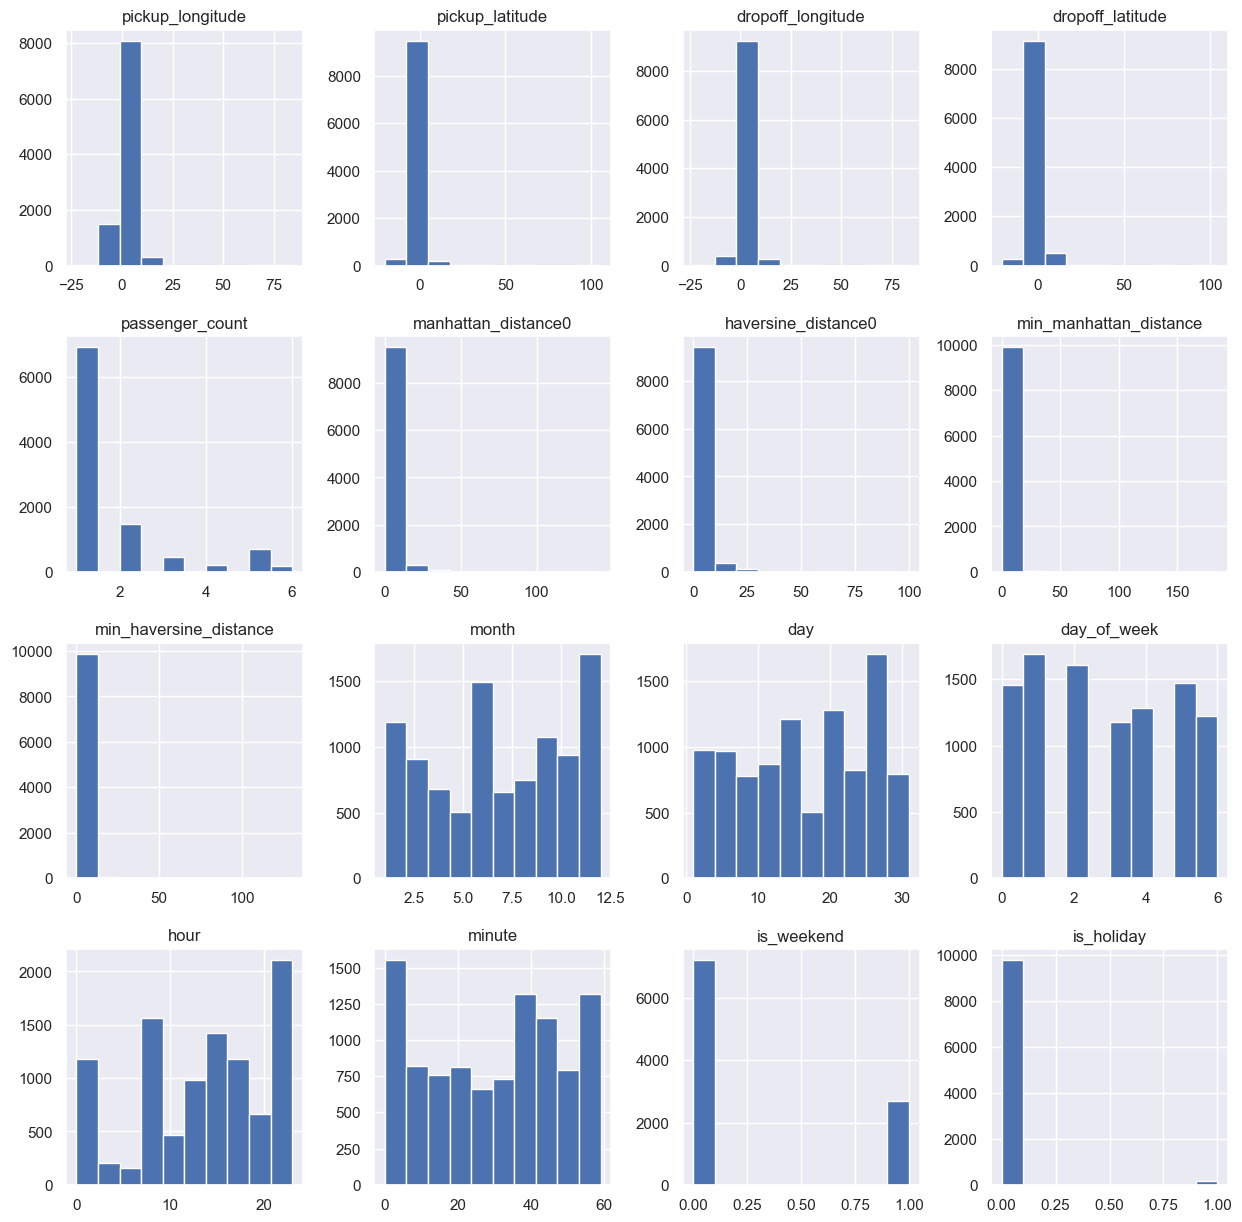

In [95]:
test.hist(figsize=(15, 15));

In [96]:
test['manhattan_distance0'].min(), test['manhattan_distance0'].max()

(0.0, 142.2)

,key,fare_amount
0,2015-01-27 13:08:24.0000002,8.988635
1,2015-01-27 13:08:24.0000003,9.244022
2,2011-10-08 11:53:44.0000002,4.967586
3,2012-12-01 21:12:12.0000002,8.572594
4,2012-12-01 21:12:12.0000003,14.718268
...,...,...
9909,2015-05-10 12:37:51.0000002,8.216916
9910,2015-01-12 17:05:51.0000001,10.504588
9911,2015-04-19 20:44:15.0000001,50.860430
9912,2015-01-31 01:05:19.0000005,19.954253


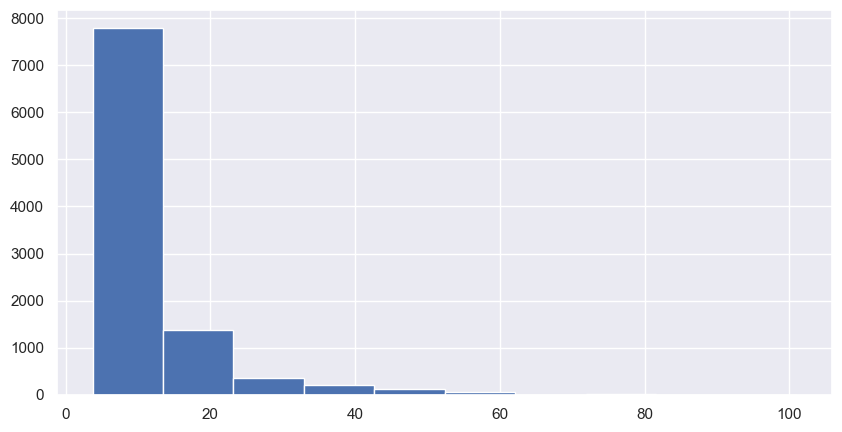

In [97]:
sub = pd.read_csv('data\sample_submission.csv')
sub['fare_amount'] = cat.predict(test)
sub['fare_amount'] = sub['fare_amount'].abs()
sub['fare_amount'].hist(figsize=(10, 5));
sub

In [98]:
sub['fare_amount'].min()

3.7052659126246468

In [99]:
sub.to_csv('gg.csv', index=False)

# ХЗ вариант

In [ ]:
# train = (train
#     .query(f'{test.pickup_longitude.min()-0.1} <= pickup_longitude <= {test.pickup_longitude.max()+0.1}')
#     .query(f'{test.pickup_latitude.min()-0.1} <= pickup_latitude <= {test.pickup_latitude.max()+0.1}')
#     .query(f'{test.dropoff_longitude.min()-0.1} <= dropoff_longitude <= {test.dropoff_longitude.max()+0.1}')
#     .query(f'{test.dropoff_latitude.min()-0.1} <= dropoff_latitude <= {test.dropoff_latitude.max()+0.1}')
# )